# Proyecto 04 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

En este proyecto integrador se trabajará con el análisis de los vehiculos que pasan por los peajes de la Ciudad de Buenos Aires.

Pensando en situaciones reales que podrían ocurrir en las cuales hay que tomar decisiones (para invertir, por ejemplo), se plantea una serie de preguntas que podríamos contestar con la ayuda de la información con la que ya contamos.

Para ello, se utilizará al igual que en proyecto anterior los datos de los años 2017, 2018 y 2019, pero trabajando con todas las estaciones y formas de pago a fines de entender tendencias de la totalidad de la población del Gran Buenos Aires. 

A continuación se presentan dos preguntas formuladas y la importancia de contestar las mismas:

- ¿Cómo se espera que varíe la utilización de cada medio de pago? Si bien en el mundo es una tendencia la mayor digitalización de tareas cotidianas, el ritmo con el que lleguen estos cambios tambien es importante. Por ejemplo, dependiendo del ritmo del cambio, podríamos tomar la decisión de despedir a alguien que trabaja en un peaje, reubicar a esa persona o que continue en su puesto normalmente, entre otras decisiones.
- Los vehiculos pesados pueden generar problemas en las calles, implicando mayores inversiones para su manteniemiento. ¿Cómo se comportará en flujo de este tipo de vehiculos en el futuro? 

Se trabajará primero en un Analisis Exploratorio de Datos, ya que en el proyecto anterior se realizó solo sobre la estación Illia en el pago por Efectivo. En Este caso se incorporarán todos los peajes y medios de pago, lo cual amerita otros análisis nuevos.

Se tendrá como referencia el RMSE obtenido en el proyecto anterior con el modelo SARIMAX (5137,7), pero de todas maneras se hará un Benchmark con la totalidad de los datos. 

Luego, se continuará con un Modelo de predicción de Árbol de Decisión, ya que fue el modelo mencionado en las conclusiones del Proyecto 03 y que se espera que presente un menor RMSE al incorporar la información de todos los atributos con los que contamos. 
Es importante destacar que la proyección que se va a realizar será del último trimestre de 2019, ya que como se observó en el proyecto anterior, la pandemia de COVID generó situaciones extremadamente atípicas. Una vez que esta situación se estabilice, sería bueno analizar nuevamente los datos.

### Análisis Exploratorio de Datos

In [18]:
# Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# Se leen los archivos
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

# Se unen los 3 datasets
dataset = pd.concat([data_2019, data_2018, data_2017])

dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [19]:
# Chequeo que los valores que toman los atributos no esten escritos de manera distinta
print(dataset['dia'].unique())
print(dataset['estacion'].unique())
print(dataset['sentido'].unique())
print(dataset['tipo_vehiculo'].unique())
print(dataset['forma_pago'].unique())

['Martes' 'Viernes' 'Lunes' 'Miércoles' 'Sábado' 'Jueves' 'Domingo']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD' 'TARJETA DISCAPACIDAD' 'MONEDERO' 'Otros']


In [20]:
# Para facilitar los análisis, se colocará un número al frente del día de semana
dataset = dataset.replace("Lunes"    , "1 Lunes"    )
dataset = dataset.replace("Martes"   , "2 Martes"   )
dataset = dataset.replace("Miércoles", "3 Miercoles")
dataset = dataset.replace("Jueves"   , "4 Jueves"   )
dataset = dataset.replace("Viernes"  , "5 Viernes"  )
dataset = dataset.replace("Sábado"   , "6 Sabado"   )
dataset = dataset.replace("Domingo"  , "7 Domingo"  )

# Cambio el nombre de la columna que contiene el día de la semana
dataset.rename(columns = {'dia':'dia_sem'}, inplace = True) 

# Corrijo la estación Alberdi y unifico Dellepiane
dataset = dataset.replace({'Dellepiane Centro':'Dellepiane', 'Dellepiane Liniers':'Dellepiane', 'Alberti':'Alberdi'})

# Corrijo Tarjeta Discapacidad
dataset = dataset.replace("T. DISCAPACIDAD","TARJETA DISCAPACIDAD")

dataset

,periodo,fecha,hora_inicio,hora_fin,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,2 Martes,Alberdi,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,2 Martes,Alberdi,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,2 Martes,Alberdi,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,2 Martes,Alberdi,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,2 Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,7 Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,7 Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,7 Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,7 Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [21]:
# Paso la fecha a formato datetime junto con hora_fin como hora, y luego quito ambas columnas
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

# Tambien quito la columna hora_inicio, periodo y dia
dataset.drop(columns=['hora_inicio','periodo'], inplace = True)

# Reordeno el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

# Agrego columnas de trabajo para el AED
dataset["año"]       = dataset["fecha"].dt.year
dataset["trimestre"] = dataset["fecha"].dt.quarter
dataset["mes"]       = dataset["fecha"].dt.month
dataset["dia"]       = dataset["fecha"].dt.day
dataset["hora"]      = dataset["fecha"].dt.hour

dataset

,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,año,trimestre,mes,dia,hora
0,7 Domingo,Dellepiane,Centro,Liviano,NO COBRADO,6,2017-01-01 00:00:00,2017,1,1,1,0
1,7 Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01 00:00:00,2017,1,1,1,0
2,7 Domingo,Illia,Provincia,Liviano,NO COBRADO,3,2017-01-01 00:00:00,2017,1,1,1,0
3,7 Domingo,Dellepiane,Provincia,Liviano,INFRACCION,3,2017-01-01 00:00:00,2017,1,1,1,0
4,7 Domingo,Avellaneda,Centro,Liviano,NO COBRADO,36,2017-01-01 00:00:00,2017,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3560701,2 Martes,Dellepiane,Provincia,Pesado,TELEPASE,13,2019-12-31 23:00:00,2019,4,12,31,23
3560702,2 Martes,Dellepiane,Provincia,Pesado,NO COBRADO,1,2019-12-31 23:00:00,2019,4,12,31,23
3560703,2 Martes,Dellepiane,Provincia,Pesado,EXENTO,2,2019-12-31 23:00:00,2019,4,12,31,23
3560704,2 Martes,Dellepiane,Provincia,Liviano,TELEPASE,150,2019-12-31 23:00:00,2019,4,12,31,23


Ahora que el dataset ya esta listo para trabajar, se exportará como csv para tener disponible cuando se cierre el notebook.

In [22]:
# Exporto como csv el dataset
dataset.to_csv('dataset_proyecto_integrador.csv')

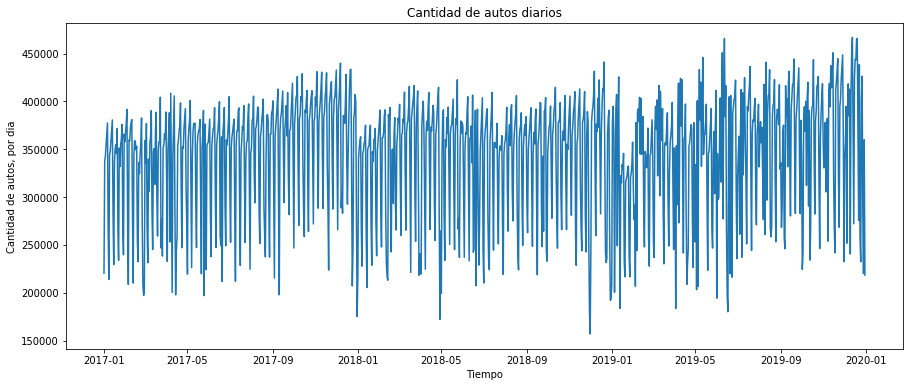

In [23]:
# Comportamiento diario de la circulación

diario = dataset.resample('D', on = 'fecha').sum()

diario.drop(columns=['año','trimestre','mes','dia','hora'], inplace = True)

plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title("Cantidad de autos diarios")
plt.show()

El gráfico diario se vuelve bastante difuso y complejo de interpretar. Se procederá a resamplear los datos de manera semanal para obtener un gráfico más comprensible

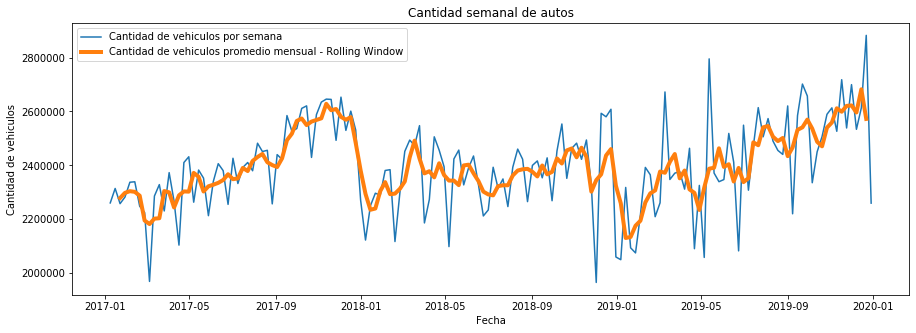

In [24]:
# Resampleo semanalmente los datos
semanal = dataset.resample('W', on = 'fecha').sum()
semanal.drop(columns = ["año","trimestre", "mes", "dia", "hora"], inplace = True)

# Elimino la primer y última fila ya que no son semanas completas
semanal.drop(semanal.index[0], inplace = True)                     
semanal.drop(semanal.index[-1], inplace = True)

# Tambien obtenemos la curva con un rolling de 4 semanas 
semanal_promedio_tendencia = semanal.cantidad_pasos.rolling(window = 4, center = True).mean()

# Grafico ambas curvas
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Cantidad de vehiculos por semana')
plt.plot(semanal_promedio_tendencia, lw = 4, label = 'Cantidad de vehiculos promedio mensual - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.title("Cantidad semanal de autos")
plt.legend()
plt.show()

Se observa que a principio de año cae el tráfico, probablemente debido a las vacaciones, y luego continua aumentando a lo largo del año. Sin embargo, 2018 se ve bastante estable con respecto a los otros dos años.

A continuación veremos la estacionalidad dentro de la semana.

Text(0.5, 1.0, 'Cantidad de vehiculos por dia de la semana, por año')

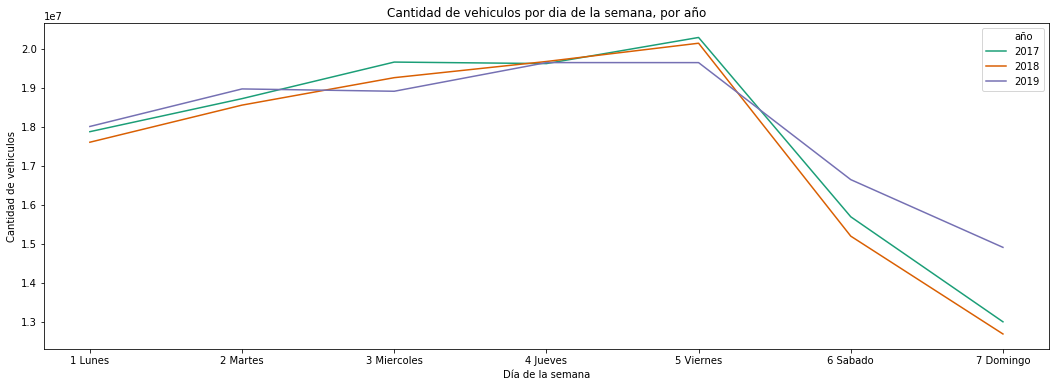

In [25]:
# ¿Se tiene el mismo comportamiento de acuerdo al día de la semana a través de los años?

dia_sem = dataset.groupby(["año","dia_sem"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (18,6))

sns.lineplot(data = dia_sem, x = "dia_sem", y = "cantidad_pasos", hue = "año", palette = "Dark2")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por dia de la semana, por año")

El comportamiento es estable a través de los años, es decir, tenemos fines de semanas con poco tránsito mientras que los días de semana son más altos.

Text(0.5, 1.0, 'Cantidad de vehiculos por dia de la semana, por peaje')

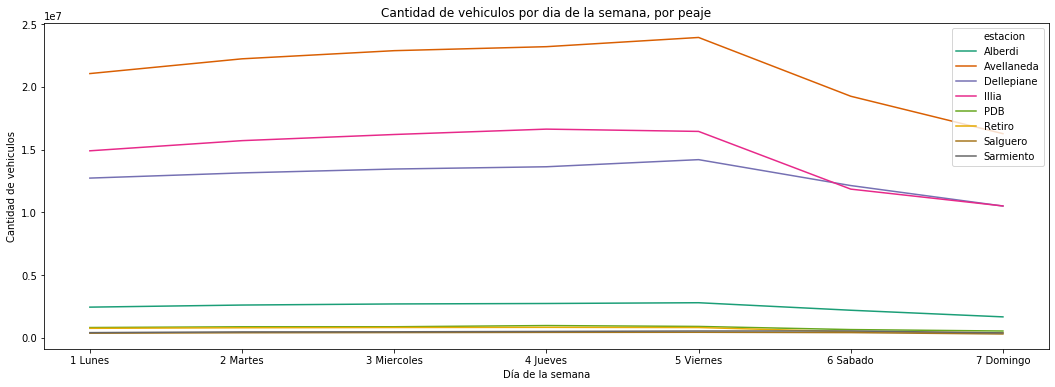

In [26]:
# ¿El comportamiento por día de la semana es similar entre estaciones?

dia_sem_peaje = dataset.groupby(["estacion","dia_sem"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (18,6))

sns.lineplot(data = dia_sem_peaje, x = "dia_sem", y = "cantidad_pasos", hue = "estacion", palette = "Dark2")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por dia de la semana, por peaje")

Tanto Avellaneda como Illia presentan un comportamiento similar, mientras que en Dellepiane no cae tan abruptamente el tránsito durante el fin de semana. Las otras estaciones presentan poco tránsito, por lo cual es dificil llegar a una conclusión de manera gráfica.

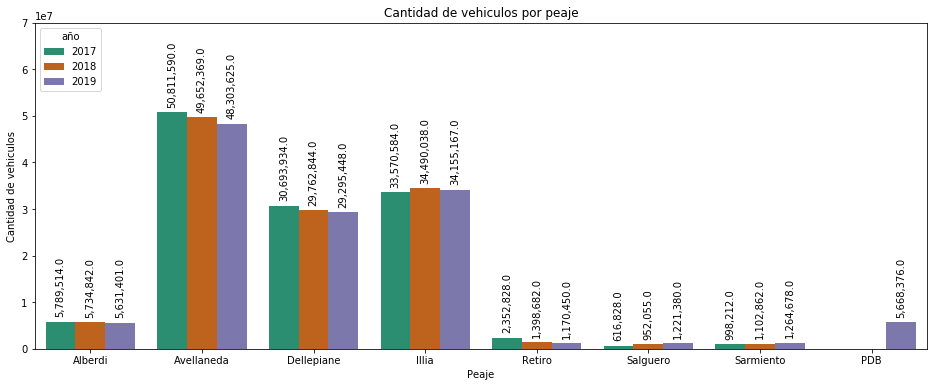

In [27]:
# ¿Cómo varió el flujo en cada estación a través de los años?

sentido_tipo = dataset.groupby(["año","estacion"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (16,6))

barplt = sns.barplot(data = sentido_tipo, x = "estacion", y = "cantidad_pasos", hue = "año", palette = "Dark2")
plt.ylim(0, 70000000)
plt.xlabel("Peaje")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por peaje")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

Como vimos anteriormente, Avellaneda, Illia y Dellepiane son los peajes más transitados y con mucha diferencia del resto.
Podemos observar que solo Illia se mantiene estable entre los más transitados. Tambien se destaca el peaje del Paseo Del Bajo (PDB) que empezó a registrar tránsito en 2019. Es probable que la caída de algunos de los otros peajes se deba a esta apertura.

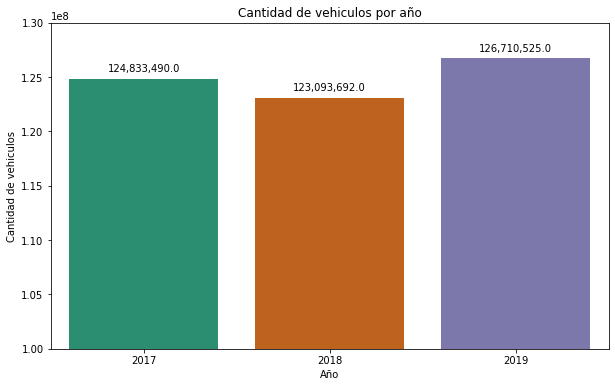

In [28]:
# ¿Cómo varió el flujo a través de los años?

sentido_tipo = dataset.groupby(["año"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (10,6))

barplt = sns.barplot(data = sentido_tipo, x = "año", y = "cantidad_pasos", palette = "Dark2")
plt.ylim(100000000, 130000000)
plt.xlabel("Año")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por año")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     ha='center',
     va=va)
plt.show()

En el gráfico de arriba vemos que si bien cae la cantidad de vehiculos en 2018 respecto 2017, aumenta en 2019.
La incorporación de PDB seguramente influyó en este aumento.

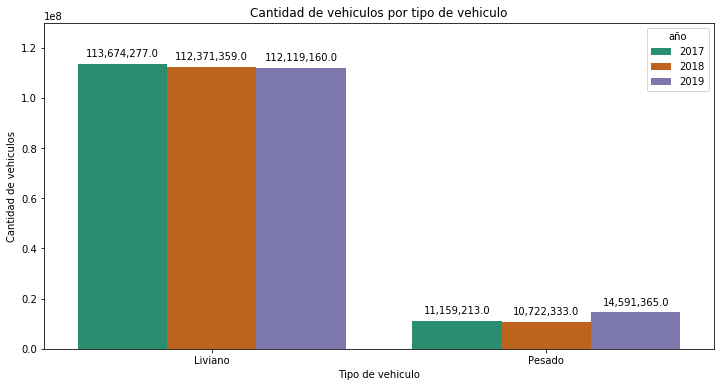

In [29]:
# ¿Cómo varió el flujo por tipo de vehiculo a través de los años?

sentido_tipo = dataset.groupby(["año","tipo_vehiculo"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (12,6))

barplt = sns.barplot(data = sentido_tipo, x = "tipo_vehiculo", y = "cantidad_pasos", hue = "año", palette = "Dark2")
plt.ylim(0, 130000000)
plt.xlabel("Tipo de vehiculo")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por tipo de vehiculo")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     ha='center',
     va=va)
plt.show()

Se observa un comportamiento estable en los vehiculos livianos, mientras que los pesados aumentaron significativamente en 2019.

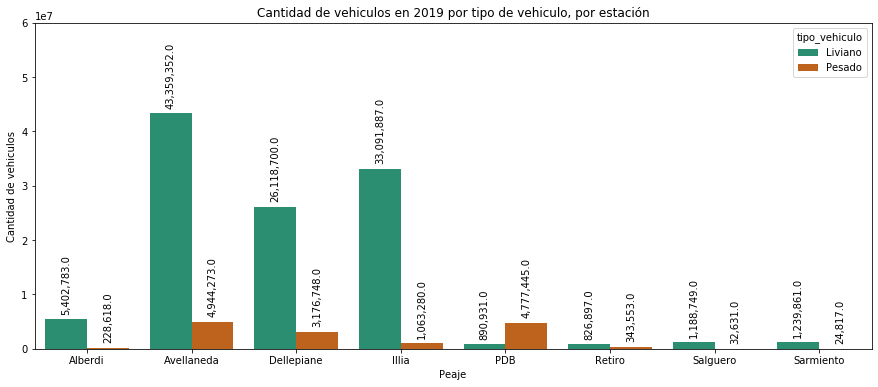

In [30]:
# Gráfico de tipo de vehiculo por estación

data_2019 = dataset[dataset['año'] == 2019]

estacion_tipo = data_2019.groupby(["estacion","tipo_vehiculo"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (15,6))

barplt = sns.barplot(data = estacion_tipo, x = "estacion", y = "cantidad_pasos", hue = "tipo_vehiculo", palette = "Dark2")
plt.ylim(0, 60000000)
plt.xlabel("Peaje")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos en 2019 por tipo de vehiculo, por estación")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

El gráfico de arriba nos muestra que por PDB, la mayor cantidad de vehiculos son pesados. Esto va en concordancia con lo observado anteriormente, es decir, el aumento de vehiculos pesados en 2019 y la apertura de PDB.

Text(0.5, 1.0, 'Cantidad de vehiculos por horario y sentido de circulación')

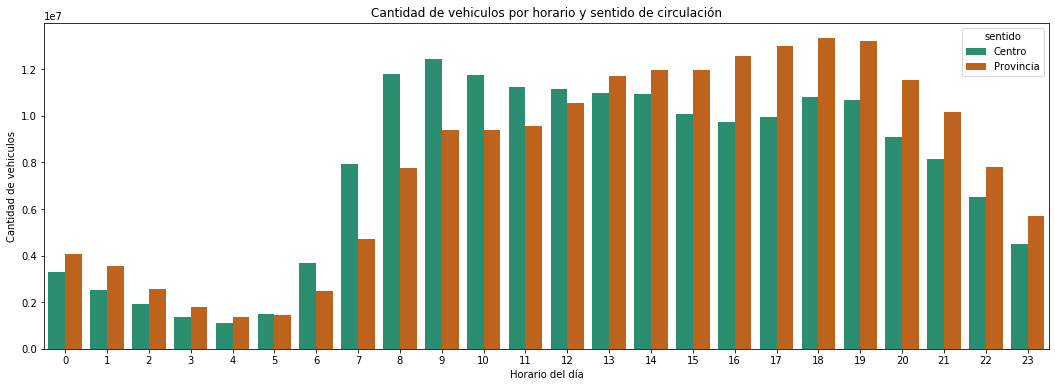

In [31]:
# ¿Cómo es el flujo de vehiculos en cada sentido de acuerdo al horario?

horario_sent = dataset.groupby(["hora","sentido"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (18,6))

sns.barplot(data = horario_sent, x = "hora", y = "cantidad_pasos", hue = "sentido", palette = "Dark2")
plt.xlabel("Horario del día")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por horario y sentido de circulación")

Se observa en el gráfico superior el efecto del horario laboral, es decir, muchas más personas yendo hacia el Centro en las primeras horas del día mientras que el flujo se invierte hacia la tarde.

Text(0.5, 1.0, 'Cantidad de vehiculos por horario y sentido de circulación - Fines de semana')

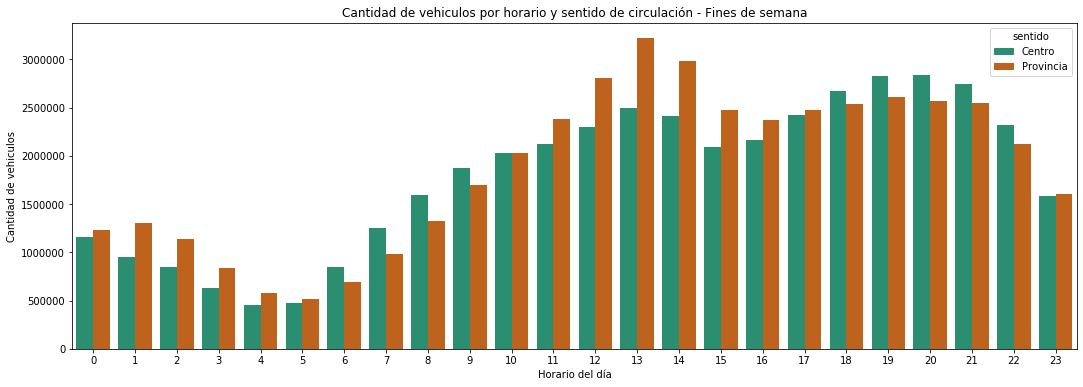

In [32]:
# ¿Cómo es el flujo de vehiculos en cada sentido de acuerdo al horario en los fines de semana?

mask = np.logical_or(dataset.dia_sem == '6 Sabado', dataset.dia_sem == '7 Domingo')
dataset_fds = dataset[mask]

horario_sent = dataset_fds.groupby(["hora","sentido"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (18,6))

sns.barplot(data = horario_sent, x = "hora", y = "cantidad_pasos", hue = "sentido", palette = "Dark2")
plt.xlabel("Horario del día")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por horario y sentido de circulación - Fines de semana")

En los fines de semana se ve otro comportamiento distinto. Se ve un flujo hacia provincia cerca del mediodía, lo cual puede explicarse por reuniones familiares o sociales, mientras que hacia la tarde la gente regresa hacia el Centro.

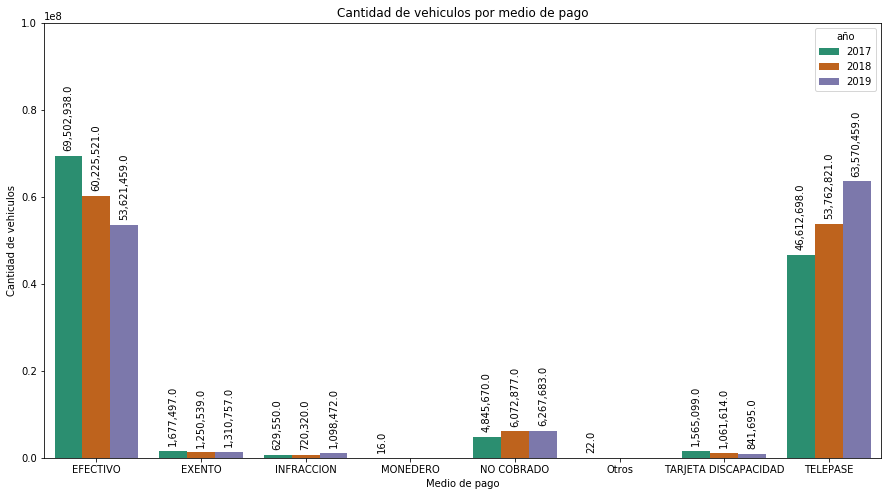

In [33]:
# ¿Cómo varió cada medio de pago a través de los años?

sentido_tipo = dataset.groupby(["año","forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (15,8))

barplt = sns.barplot(data = sentido_tipo, x = "forma_pago", y = "cantidad_pasos", hue = "año", palette = "Dark2")
plt.ylim(0, 100000000)
plt.xlabel("Medio de pago")
plt.ylabel("Cantidad de vehiculos")
plt.title("Cantidad de vehiculos por medio de pago")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

Observamos que Efectivo y Telepase son los medios de pago más utilizados.

Tal como se supuso en el inicio de este proyecto, la tendencia es que la gente opte cada vez más hacia medios digitales de pago.

### Modelo de Machine Learning

A continuación se realizará un modelo Benchmark (Regresión Lineal) para tener como referencia. Luego, se continuará con un Árbol de Decisión y posteriormente se optimizarán sus hiperparámetros.

Como se explicó al inicio de este proyecto, se proyectará el último trimestre de 2019 ya que analizarlo con los datos del 2020 no sería representativo por la pandemia del COVID-19.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# Importo el dataset obtenido originalmente
dataset = pd.read_csv('dataset_proyecto_integrador.csv', sep =',')

# Quito las columnas de trabajo
dataset.drop(columns = ["Unnamed: 0","año","trimestre","mes","dia","hora"], inplace = True)

# Simplifico la fecha eliminando la hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha).dt.date
dataset.drop(columns = ['fecha'], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True)

# Agrupo por cada uno de los atributos para que quede una base de datos mas sencilla
dataset = dataset.groupby(["dia_sem","estacion","sentido","tipo_vehiculo","forma_pago","fecha"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

dataset

,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,fecha,cantidad_pasos
0,1 Lunes,Alberdi,Centro,Liviano,EFECTIVO,2017-01-02,3866
1,1 Lunes,Alberdi,Centro,Liviano,EFECTIVO,2017-01-09,4078
2,1 Lunes,Alberdi,Centro,Liviano,EFECTIVO,2017-01-16,4198
3,1 Lunes,Alberdi,Centro,Liviano,EFECTIVO,2017-01-23,3915
4,1 Lunes,Alberdi,Centro,Liviano,EFECTIVO,2017-01-30,4157
...,...,...,...,...,...,...,...
121550,7 Domingo,Sarmiento,Provincia,Pesado,TELEPASE,2019-12-01,26
121551,7 Domingo,Sarmiento,Provincia,Pesado,TELEPASE,2019-12-08,82
121552,7 Domingo,Sarmiento,Provincia,Pesado,TELEPASE,2019-12-15,22
121553,7 Domingo,Sarmiento,Provincia,Pesado,TELEPASE,2019-12-22,17


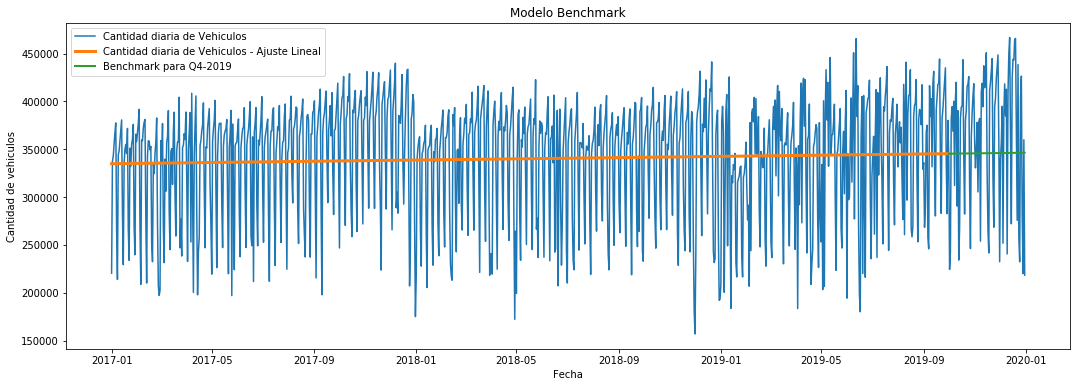

In [2]:
### Modelo Benchmark: Regresión Lineal

# Resampleo los datos de manera diaria
diario = dataset.groupby(["fecha"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")


# Hago la Regresión Lineal
diario['fecha_numeros'] = diario.fecha.map(datetime.datetime.toordinal)
diario.set_index('fecha', inplace = True)

split_date = datetime.date(2019, 9, 30)

train = diario.loc[diario.index <= split_date].copy()
test  = diario.loc[diario.index >  split_date].copy()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train.fecha_numeros.values.reshape(-1, 1), train.cantidad_pasos)


# Grafico los datos originales, la regresión lineal y la predicción
plt.figure(figsize = (18,6))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(train.index, lr.predict(train.fecha_numeros.values.reshape(-1, 1)), lw = 3, label = 'Cantidad diaria de Vehiculos - Ajuste Lineal')
plt.plot(test.index,  lr.predict(test.fecha_numeros.values.reshape(-1, 1)),  lw = 2, label = 'Benchmark para Q4-2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Benchmark")
plt.show()

In [3]:
# Calculo de error del Benchmark

from sklearn.metrics import mean_squared_error
rmse_bench = np.sqrt(mean_squared_error(test.cantidad_pasos, lr.predict(test.fecha_numeros.values.reshape(-1, 1))))

print('RMSE modelo Benchmark: %.1f' % rmse_bench)

RMSE modelo Benchmark: 72563.1


El RMSE obtenido mayor al obtenido en el proyecto anterior, pero era una situación esperable ya que contamos con mayor cantidad de datos y más tráfico.

A continuación se realizará el Árbol de Decisión usando los hiperparámetros por default del modelo:

In [4]:
### Modelo de regresión: Árbol de Decisión

# Para facilitar el trabajo del modelo, se dejarán solo 4 valores en medio de pago: Efectivo, Telepase, No cobrado y Otros medios de pago
dataset = dataset.replace({"EXENTO":"Otros medios de pago",
                           "INFRACCION":"Otros medios de pago", 
                           "MONEDERO":"Otros medios de pago", 
                           "TARJETA DISCAPACIDAD":"Otros medios de pago", 
                           "Otros":"Otros medios de pago"})

# Lo mismo se realizará para las estaciones de peaje, dejando solo las 3 de mayor tránsito
dataset = dataset.replace({"Alberdi":"Resto peajes",
                           "Retiro":"Resto peajes", 
                           "Salguero":"Resto peajes", 
                           "Sarmiento":"Resto peajes", 
                           "PDB":"Resto peajes"})


# Convierto en número la fecha para que no se vuelva una variable dummie
dataset['fecha_numeros'] = dataset.fecha.map(datetime.datetime.toordinal)
dataset = dataset.drop(columns = ["fecha"])


# Genero variables dummies para poder trabajar los atributos categoricos
dataset = pd.get_dummies(dataset)


# Separo el dataset en Train y Test
split_date = datetime.date(2019, 9, 30)
split_date = split_date.toordinal()

train = dataset.loc[dataset.fecha_numeros <= split_date].copy()
test  = dataset.loc[dataset.fecha_numeros >  split_date].copy()

X_train = train.drop(columns = ["cantidad_pasos"])
X_test  = test.drop(columns = ["cantidad_pasos"])

y_train = train.cantidad_pasos
y_test  = test.cantidad_pasos

# Genero el modelo

from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred  = tree_model.predict(X_test)

RMSE Train modelo Árbol de Decisión: 502.3
RMSE Test modelo Árbol de Decisión: 1881.1


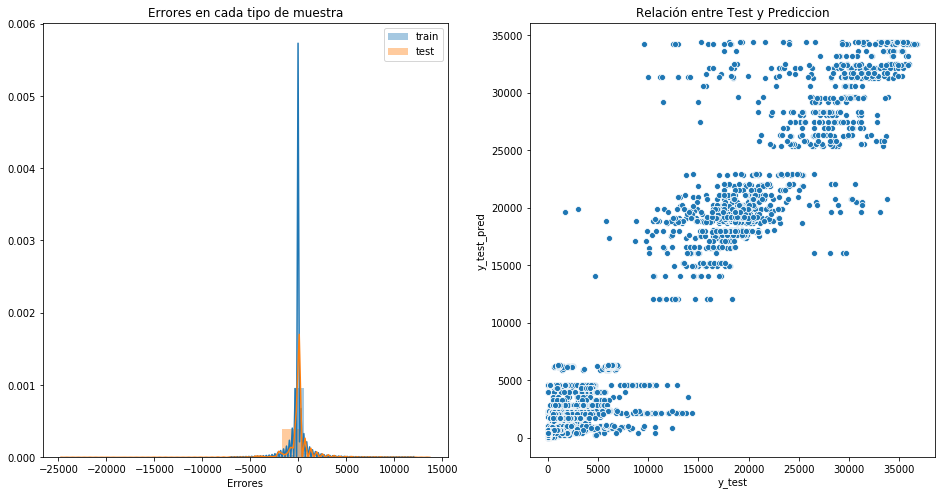

In [5]:
# Calculo de error del Árbol de Decisión

from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('RMSE Train modelo Árbol de Decisión: %.1f' % rmse_train)
print('RMSE Test modelo Árbol de Decisión: %.1f' % rmse_test)


# Gráfico del error

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)

sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()
plt.title("Errores en cada tipo de muestra")

plt.subplot(1,2,2)

sns.scatterplot(y_test,y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title("Relación entre Test y Prediccion")

plt.show()

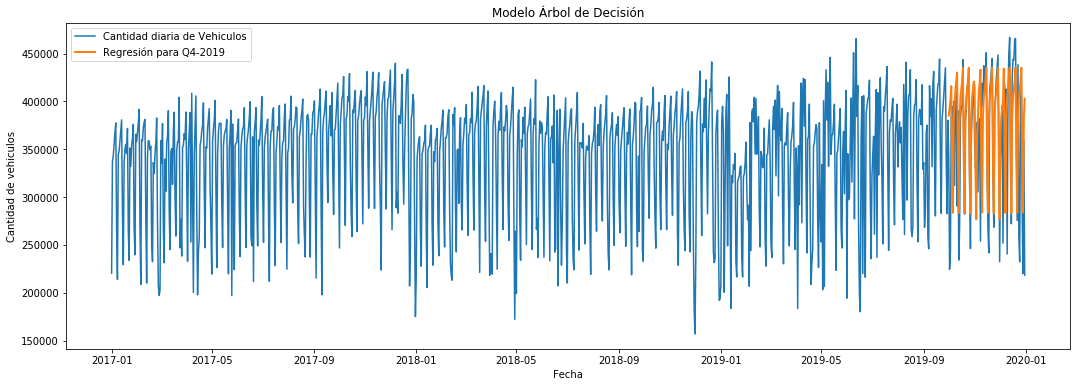

In [6]:
# Grafico los datos originales y la predicción
plt.figure(figsize = (18,6))

test['fecha'] = test.fecha_numeros.map(datetime.datetime.fromordinal)
test['prediccion'] = y_test_pred

test = test.groupby(["fecha"])[("prediccion")].sum().reset_index(name="prediccion")

test.set_index('fecha', inplace = True)

plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(test.index,  test.prediccion,  lw = 2, label = 'Regresión para Q4-2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Árbol de Decisión")
plt.show()

El modelo en su primera versión tuvo un resultado muy bueno, obteniendo un RMSE signitivamente menor que el del modelo Benchmark y que el obtenido en el proyecto anterior. Sin embargo, se observa que hay overfitting en el modelo.

Se continuará con un Grid Search para mejorar el modelo ya que se considera que el RMSE es bastante bajo y es probable que una optimización por Random Search no muestre una mejora considerable.

In [14]:
### Grid Search para Árbol de Decisión

import time
start = time.time()

# Genero la grilla

param_dist = {'min_samples_split' : np.arange(2,6),
              'min_samples_leaf'  : np.arange(1,5),
              'max_depth'         : np.arange(1,200)}

# Genero el Árbol de Decisión
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()

# Grid Search
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(tree_model, param_grid = param_dist, cv=5)
model.fit(X_train, y_train)


end = time.time()
process_time = (end - start)

print("Mejores parametros: "+str(model.best_params_))

Mejores parametros: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [15]:
# Tiempo de procesamiento del Grid Search

print('Tiempo de Procesamiento del Grid Search: %.1f' % process_time)

Tiempo de Procesamiento del Grid Search: 5269.9


In [22]:
train = dataset.loc[dataset.fecha_numeros <= split_date].copy()
test  = dataset.loc[dataset.fecha_numeros >  split_date].copy()

X_train = train.drop(columns = ["cantidad_pasos"])
X_test  = test.drop(columns = ["cantidad_pasos"])

y_train = train.cantidad_pasos
y_test  = test.cantidad_pasos

# Genero el modelo

from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 4, min_samples_split = 2)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred  = tree_model.predict(X_test)

RMSE Train modelo Árbol de Decisión Optimizado: 1419.9
RMSE Test modelo Árbol de Decisión Optimizado: 1820.2


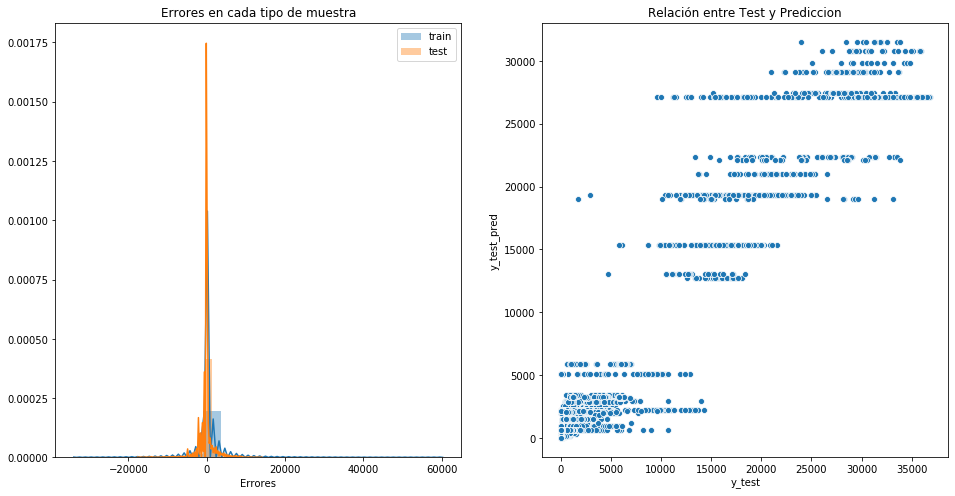

In [23]:
# Calculo de error del Árbol de Decisión

from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('RMSE Train modelo Árbol de Decisión Optimizado: %.1f' % rmse_train)
print('RMSE Test modelo Árbol de Decisión Optimizado: %.1f' % rmse_test)


# Gráfico del error

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)

sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()
plt.title("Errores en cada tipo de muestra")

plt.subplot(1,2,2)

sns.scatterplot(y_test,y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title("Relación entre Test y Prediccion")

plt.show()

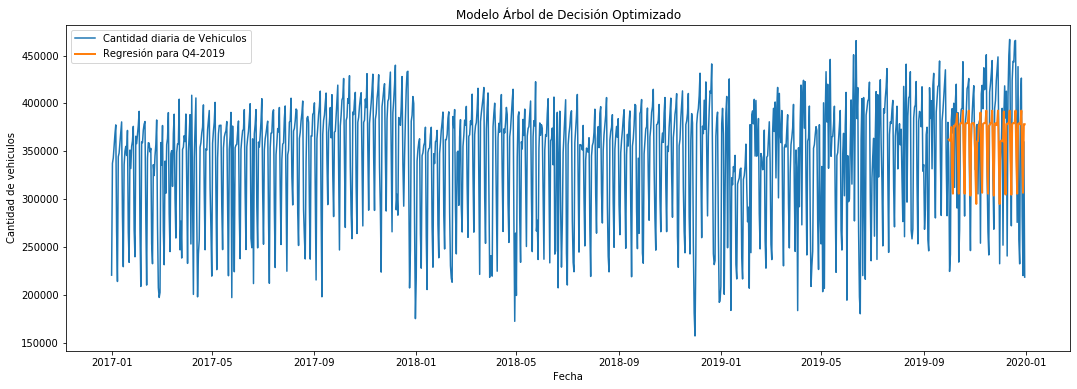

In [24]:
# Grafico los datos originales y la predicción
plt.figure(figsize = (18,6))

test['fecha'] = test.fecha_numeros.map(datetime.datetime.fromordinal)
test['prediccion'] = y_test_pred

test = test.groupby(["fecha"])[("prediccion")].sum().reset_index(name="prediccion")

test.set_index('fecha', inplace = True)

plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(test.index,  test.prediccion,  lw = 2, label = 'Regresión para Q4-2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Árbol de Decisión Optimizado")
plt.show()

Al optimizar los hiperparámetros no hubo una mejora importante en el modelo, pero si redujo bastante el overfitting.

### Conclusiones finales

A partir de implementar un modelo con otro tipo de input, es decir, que incluía la información contenida en los atributos del dataset, se pudo obtener un modelo significativamente mejor. Esto refuerza la idea de que no solo es importante contar con un modelo de trabajo adecuado, sino tambien nutrirlo con los datos correctos. Claramente para poder contar con los datos correctos, antes es necesario entender bien el punto de partida con un buen Análisis Exploratorio de Datos y el preprocesamiento de los datos.

Por último, respecto a los resultados del proyecto, considero que el modelo es altamente satisfactorio, ya que se cuenta con una herramienta que proyecta con bastante precisión el tráfico futuro y que tranquilamente podríamos tomar para responder las dos preguntas planteadas inicialmente. Sin embargo, esto no quita que los modelos de por si solos no son suficientes, necesitamos tener un entendimiento del contexto que soporte las decisiones que tomamos y que nos ayuden a interpretar los resultados. Como se planteo al principio, hacer un modelo con el tráfico que tuvimos en cuarentena no sería correcto ni para nutrir el modelo, ni para medir el desempeño de la herramienta.

La combinación del entendimiento del contexto, situación o negocio con el cual estemos trabajando con el conocimiento de las herramientas del Data Science son la clave de un proceso de toma de decisión exitoso.

### Link al repositorio en Github

https://github.com/gmishima/DS_Proyecto_Integrador